In [1]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [2]:
image_data = np.load(open('CROHME2016_img_data.npy','rb'),allow_pickle=True)

groundtruth = np.load(open('CROHME2016_groundtruth.npy','rb'),allow_pickle=True)

print(image_data.shape)
print(groundtruth.shape)

(10848, 310, 310, 3)
(10848, 53)


# Train Test Split

In [3]:
x_train, x_test, y_train, y_test = train_test_split(image_data, groundtruth, test_size=0.20, random_state=23)

In [4]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8678, 310, 310, 3) (2170, 310, 310, 3) (8678, 53) (2170, 53)


# One Hot Encoding

In [ ]:
# from keras.utils import to_categorical
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [ ]:
# print(y_train.shape)
# print(y_test.shape)

In [ ]:
#want to append (2170, 53, 5) to y_test
#initialise it entierely with 0s

# a = np.zeros(shape=(2170, 53, 5))

In [17]:
# print(x_train.shape)
# print(x_test.shape)

# print(y_train.shape)
# print(y_test.shape)

In [ ]:
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],x_train.shape[3])
# x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],x_test.shape[3])

# print(x_train.shape)

In [ ]:
# #so its still not reshaped la..
# y_train = np.transpose(y_train, (0, 2, 1))
# print(y_train.shape)

# y_test = np.transpose(y_test, (0, 2, 1))
# print(y_test.shape)

# The Keras Model

## Hyperparameters

In [5]:
batch_size = 32 #256
epochs = 40#80

In [6]:
#num_classes = 9381
#based off number of unique vocab words

In [7]:
num_classes = 53

#based off max len of sequence (post padded)

Ok so theres some confusion between input shape and model input shape

input_shape **does not contain the batch size**, while batch_input_shape is the full input shape including the batch size.

input shape would be (310, 310, 3, 1)
batch input shape would be (8678, 310, 310, 3, 1)

But  LSTM layer is a recurrent layer, hence **it expects a 3-dimensional input (batch_size, timesteps, input_dim)**

In [ ]:
#x_train_extended = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]*x_train.shape[3], 1)

In [ ]:
#x_test_extended = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]*x_test.shape[3], 1)

In [ ]:
# print(x_train_extended.shape)
# print(x_test_extended.shape)

In [ ]:
# model_input = (x_train_extended.shape[1], 1)
# print(model_input)

# #without batch size

In [17]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(8678, 310, 310, 3)
(2170, 310, 310, 3)
(8678, 53)
(2170, 53)


# THE MODEL

In [8]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D , Flatten, Dropout
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(310, 310, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('tanh'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
#model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 308, 308, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 308, 308, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 154, 154, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 152, 152, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 152, 152, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 76, 76, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        1

In [10]:
# # load weights
# model.load_weights("keras_model2.hdf5")

epochs = 10

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

In [12]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

checkpoint = ModelCheckpoint("keras_model4.hdf5", monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint])

Epoch 1/10
272/272 [==============================] - ETA: 0s - loss: 226527.8281 - accuracy: 0.0582
Epoch 00001: accuracy improved from -inf to 0.05819, saving model to keras_model4.hdf5
272/272 [==============================] - 762s 3s/step - loss: 226527.8281 - accuracy: 0.0582 - val_loss: 258161.5469 - val_accuracy: 0.0198
Epoch 2/10
272/272 [==============================] - ETA: 0s - loss: 227034.0000 - accuracy: 0.0772
Epoch 00002: accuracy improved from 0.05819 to 0.07721, saving model to keras_model4.hdf5
272/272 [==============================] - 1391s 5s/step - loss: 227034.0000 - accuracy: 0.0772 - val_loss: 6308003.5000 - val_accuracy: 0.0207
Epoch 3/10
272/272 [==============================] - ETA: 0s - loss: 235539.7344 - accuracy: 0.0882
Epoch 00003: accuracy improved from 0.07721 to 0.08815, saving model to keras_model4.hdf5
272/272 [==============================] - 754s 3s/step - loss: 235539.7344 - accuracy: 0.0882 - val_loss: 20185716.0000 - val_accuracy: 0.0336


In [14]:
# from keras.models import load_model
# model = load_model('keras_model2.hdf5')

In [15]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(score)

68/68 [==============================] - 49s 727ms/step - loss: 2422487.7500 - accuracy: 0.0221
Test loss: 2422487.75
Test accuracy: 0.02211981639266014
[2422487.75, 0.02211981639266014]


In [ ]:
model.save('shapes_cnn.h5')

In [ ]:
activations = activation_model.predict(img_tensor) 
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


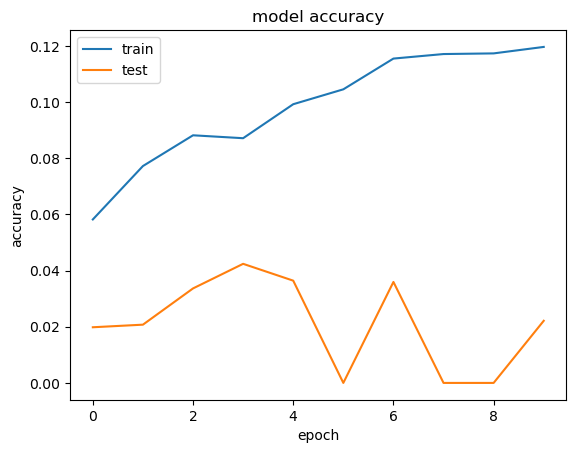

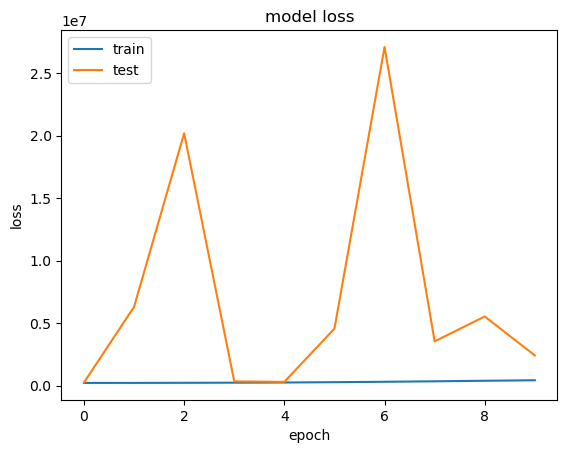

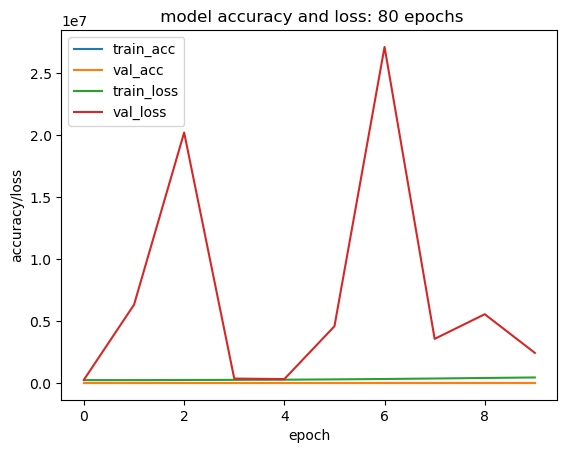

In [16]:
# list all data in history
import matplotlib.pyplot as plt 

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#trying to combine both
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' model accuracy and loss: 80 epochs')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc','train_loss','val_loss'], loc='upper left')
plt.show()

# Visualise filters

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

Attempted to do so, but did not manage to get the following code to run

In [1]:
# from keras.applications.vgg16 import VGG16
# from matplotlib import pyplot
# # load the model
# #model = VGG16()
# # retrieve weights from the second hidden layer
# filters, biases = model.layers[1].get_weights()
# # normalize filter values to 0-1 so we can visualize them
# f_min, f_max = filters.min(), filters.max()
# filters = (filters - f_min) / (f_max - f_min)
# # plot first few filters
# n_filters, ix = 6, 1
# for i in range(n_filters):
# 	# get the filter
# 	f = filters[:, :, :, i]
# 	# plot each channel separately
# 	for j in range(3):
# 		# specify subplot and turn of axis
# 		ax = pyplot.subplot(n_filters, 3, ix)
# 		ax.set_xticks([])
# 		ax.set_yticks([])
# 		# plot filter channel in grayscale
# 		pyplot.imshow(f[:, :, j], cmap='gray')
# 		ix += 1
# # show the figure
# pyplot.show()

In [3]:
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.models import Model
# from matplotlib import pyplot
# from numpy import expand_dims

In [2]:
# # using 001-equation000.png as an example

# # redefine model to output right after the first hidden layer
# ixs = [1, 4, 7] #based on model architecture
# outputs = [model.layers[i].output for i in ixs]
# model = Model(inputs=model.inputs, outputs=outputs)
# # load the image with the required shape
# img = load_img('2016_IMGS//001-equation000.png', target_size=(310, 310))
# # convert the image to an array
# img = img_to_array(img)
# # expand dimensions so that it represents a single 'sample'
# img = expand_dims(img, axis=0)
# # prepare the image (e.g. scale pixel values for the vgg)
# img = preprocess_input(img)
# # get feature map for first hidden layer
# feature_maps = model.predict(img)
# # plot the output from each block
# square = 8
# for fmap in feature_maps:
# 	# plot all 64 maps in an 8x8 squares
# 	ix = 1
# 	for _ in range(square):
# 		for _ in range(square):
# 			# specify subplot and turn of axis
# 			ax = pyplot.subplot(square, square, ix)
# 			ax.set_xticks([])
# 			ax.set_yticks([])
# 			# plot filter channel in grayscale
# 			pyplot.imshow(fmap[ ix-1], cmap='gray')
# 			ix += 1
# 	# show the figure
# 	pyplot.show()